<a href="https://colab.research.google.com/github/avpakh/wta_prognoz/blob/master/%22%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%B0_%D1%82%D0%B5%D0%BD%D0%B8%D1%81%D0%BD%D1%8B%D1%85_%D0%BC%D0%B0%D1%82%D1%87%D0%B5%D0%B9_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B0__ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Загрузка библиотек
import requests
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=8)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans 
import tensorflow as tf
import pickle

In [2]:
# Загрузка данных 
url = "https://raw.githubusercontent.com/avpakh/wta_prognoz/master/dataset.csv"
response = requests.get(url)
dest = 'C:\\Projects\\dataset1.csv' # локальный
with open(dest, 'wb') as file:
    file.write(response.content)

df = pd.read_csv(dest,sep='^')

In [3]:
# Приведение дат к единому формату
df['match_date'] = pd.to_datetime(df['match_date'].str.strip(), format='%Y-%m-%d')
df['dob_winner'] = pd.to_datetime(df['dob_winner'].str.strip(), format='%Y-%m-%d')
df['dob_loser'] = pd.to_datetime(df['dob_loser'].str.strip(), format='%Y-%m-%d')
df['diff_phi1']  = df['bio_phi_winner'] -  df['bio_phi_loser']
df['diff_emo1']  = df['bio_emo_winner'] -  df['bio_emo_loser']
df['diff_int1']  = df['bio_int_winner'] -  df['bio_int_loser']
df['diff_age1'] = (df['dob_winner'] - df['dob_loser']).dt.days
df['diff_phi2']  = df['bio_phi_loser'] - df['bio_phi_winner']
df['diff_emo2']  = df['bio_emo_loser'] - df['bio_emo_winner'] 
df['diff_int2']  = df['bio_int_loser'] -  df['bio_int_winner']
df['diff_age2'] = (df['dob_loser'] - df['dob_winner']).dt.days
df['combine_winner'] = df['bio_phi_winner'] + df['bio_emo_winner'] +  df['bio_int_winner']
df['combine_loser'] = df['bio_phi_loser'] + df['bio_emo_loser'] + df['bio_int_loser']
df['age_winner'] =  (df['match_date'] - df['dob_winner'] ).dt.days
df['age_loser'] =   (df['match_date'] - df['dob_loser'] ).dt.days
df['diff1'] = df['combine_winner'] - df['combine_loser']
df['diff2'] = df['combine_loser'] - df['combine_winner']
df['diff_rank1'] = df['winner_rank']- df['loser_rank']
df['diff_rank2'] = df['loser_rank'] - df['winner_rank']


In [7]:
df_winner = df
df_loser  = df

df_winner = df_winner.drop(columns=['age_loser','combine_loser','loser_id','height_loser','loser_rank','loser_rank_points','height_loser','hand_class_loser','dob_loser','bio_phi_loser','bio_emo_loser','bio_int_loser','loser','critical_loser','diff_age2','diff2','diff_phi2','diff_emo2','diff_int2','diff_rank2'])
df_winner['y'] = 1

df_loser = df_loser.drop(columns=['age_winner','combine_winner','winner_id','height_winner','winner_rank','winner_rank_points','height_winner','hand_class_winner','dob_winner','bio_phi_winner','bio_emo_winner','bio_int_winner','winner','critical_winner','diff_age1','diff1','diff_phi1','diff_emo1','diff_int1','diff_rank1'])
df_loser['y'] = 0

df_winner.rename(columns = {'age_winner':'age','combine_winner':'combine','winner':'player', 'hand_class_winner': 'hand_class','winner_id':'player_id',
                            'dob_winner': 'dob', 'height_winner' : 'height', 'winner_rank':'rank', 'winner_rank_points':'points', 'bio_phi_winner': 'bio_phi',
                            'bio_emo_winner' : 'bio_emo',  'bio_int_winner' : 'bio_int' , 'critical_winner':'critical','diff_age1':'diff_age',
                            'diff_phi1':'diff_phi','diff_emo1':'diff_emo','diff_int1':'diff_int','diff1':'diff','diff_rank1':'diff_rank'}, inplace = True)
df_loser.rename(columns = {'age_loser':'age','combine_loser': 'combine','loser':'player', 'hand_class_loser': 'hand_class','loser_id':'player_id',
                           'dob_loser': 'dob', 'height_loser' : 'height', 'loser_rank':'rank', 'loser_rank_points':'points', 'bio_phi_loser':
                           'bio_phi', 'bio_emo_loser' : 'bio_emo',  'bio_int_loser' : 'bio_int' , 'critical_loser':'critical',
                            'diff_age2':'diff_age',  'diff_phi2':'diff_phi','diff_emo2':'diff_emo','diff_int2':'diff_int','diff2':'diff','diff_rank2':'diff_rank'}, inplace = True)


joint_dataset = pd.concat([df_winner, df_loser], axis=0)

In [8]:
joint_dataset = joint_dataset.drop(columns = ['id_testdataset',	'match_date','tourney_name','tourney_location','height','critical','dob','player','player_id','tier','court','round','surface','hand_class'],axis=1)

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [10]:
 t = clean_dataset(joint_dataset)
 y = t['y']
 t = t.drop(columns=['y'])
 X = t

In [11]:
X[:5]

,rank,points,bio_phi,bio_emo,bio_int,diff_phi,diff_emo,diff_int,diff_age,combine,age,diff,diff_rank
0,54.0,420.0,113.616665,77.747907,197.181157,-2.400213e-11,-65.640467,60.014911,-2645.0,388.545728,10039.0,-5.625556,-545.0
1,88.0,319.0,139.840109,162.348980,13.397460,-2.326869e+01,-37.651020,-11.027583,-760.0,315.586549,8635.0,-71.947288,10.0
2,165.0,169.0,151.958395,100.000000,197.181157,1.407469e+02,-97.492791,97.181157,-1294.0,449.139552,9478.0,140.435282,133.0
3,70.0,365.0,86.383335,190.096887,71.826744,3.834173e+01,152.445867,-18.667651,3068.0,348.306966,6981.0,172.119946,24.0
4,66.0,382.0,126.979677,37.651020,137.166246,-4.610392e+01,-40.096887,-62.720488,2118.0,301.796942,7361.0,-148.921294,-99.0


In [12]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)


In [13]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.


In [14]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

                   Logistic Regression: 64.04%
                   K-Nearest Neighbors: 55.88%
                         Decision Tree: 56.35%
Support Vector Machine (Linear Kernel): 50.29%
   Support Vector Machine (RBF Kernel): 61.99%
                        Neural Network: 58.42%
                         Random Forest: 63.86%
                     Gradient Boosting: 64.93%


Accuracy: 0.64
Precision: 0.66
Recall: 0.59
F-Score: 0.62

Confusion Matrix


Text(30.5, 0.5, 'True')

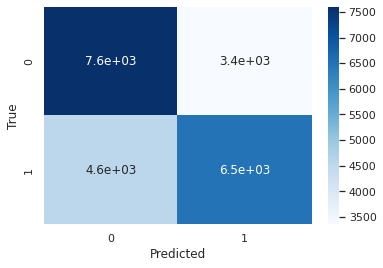

In [15]:
# Initialize a logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter=2500, random_state=42)

# Train (fit) the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test) # Predictions
y_true = y_test # True values

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

print("Accuracy:", np.round(accuracy_score(y_true, y_pred), 2))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred,
                                                               average='binary')
print("Precision:", np.round(precision, 2))
print("Recall:", np.round(recall, 2))
print("F-Score:", np.round(fscore, 2))

# Make the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [19]:
from keras.models import Sequential
ANN_model = Sequential()

from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense

ANN_model.add(tf.keras.layers.InputLayer(input_shape=(13, )))
    # No hidden layers
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(128, activation='relu')),
ANN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
ANN_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



In [20]:
ANN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1792      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                

In [21]:
history = ANN_model.fit(X_train, y_train, 
                        epochs=200, batch_size=32,
                        validation_split=0.2, 
                        shuffle=False)

Epoch 1/200
1284/1284 [==============================] - 13s 9ms/step - loss: 1.7879 - accuracy: 0.5391 - val_loss: 1.0664 - val_accuracy: 0.5872
Epoch 2/200
1284/1284 [==============================] - 7s 5ms/step - loss: 1.1965 - accuracy: 0.5540 - val_loss: 0.9121 - val_accuracy: 0.5899
Epoch 3/200
1284/1284 [==============================] - 5s 4ms/step - loss: 1.0377 - accuracy: 0.5604 - val_loss: 0.7677 - val_accuracy: 0.5960
Epoch 4/200
1284/1284 [==============================] - 5s 4ms/step - loss: 0.9366 - accuracy: 0.5602 - val_loss: 0.7886 - val_accuracy: 0.5687
Epoch 5/200
1284/1284 [==============================] - 5s 4ms/step - loss: 0.8377 - accuracy: 0.5644 - val_loss: 0.7838 - val_accuracy: 0.5741
Epoch 6/200
1284/1284 [==============================] - 5s 4ms/step - loss: 0.7847 - accuracy: 0.5706 - val_loss: 0.7022 - val_accuracy: 0.6116
Epoch 7/200
1284/1284 [==============================] - 5s 4ms/step - loss: 0.7417 - accuracy: 0.5772 - val_loss: 0.7698 - val_a

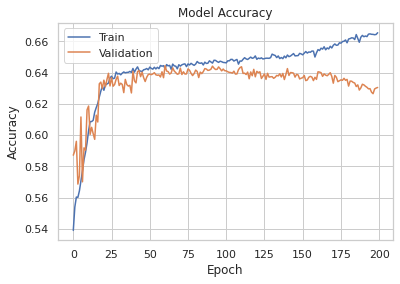

In [22]:
# Plot training and validation accuracy scores
# against the number of epochs.
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

In [23]:
with open('model.obj', 'wb') as f:
  pickle.dump(ANN_model, f)

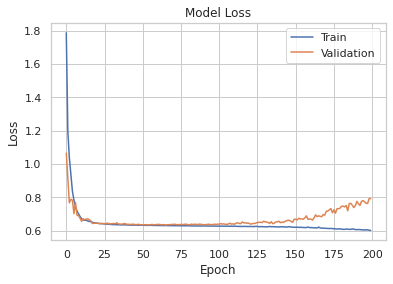

In [24]:
# Plot training and validation loss scores
# against the number of epochs.
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')